In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

from shapely.geometry import Polygon

def bb_to_poly(lon1,lat1,lon2,lat2):
    """
    This function creates a rectangular bounding box of SW and NE lon/lat coordinates.
    Input order is lonmin,latmin (SW), lonmax,latmax (NE).
    """
    return [(lon1,lat1),(lon1,lat2),(lon2,lat2),(lon2,lat1)]

from copy import deepcopy

In [4]:
# specify the custom font to use
plt.rcParams['font.family'] = 'sans-serif'
# installed font from attached 'reynold.zip'
plt.rcParams['font.sans-serif'] = 'Reynold'
# background color of figures
plt.rcParams['figure.facecolor'] = 'white'

In [5]:
# defining aspect ratio of all plots
bb_dimensions = [18.99,47.43539,19.131389,47.551377]
dx = bb_dimensions[2]-bb_dimensions[0]
dy = bb_dimensions[3]-bb_dimensions[1]

In [6]:
from pyproj import Transformer

In [7]:
# base OSM files, bounding boxes, display names, and coordinate reference systems for the 4 maps
# OSM files have been downloaded from geofabrik, and unzipped into the corresponding folders
#
# https://download.geofabrik.de/europe/austria-latest-free.shp.zip
# https://download.geofabrik.de/europe/switzerland-latest-free.shp.zip
# http://download.geofabrik.de/europe/netherlands/noord-holland-latest-free.shp.zip
# https://download.geofabrik.de/europe/hungary-latest-free.shp.zip
#
# bounding boxes hand-drawn from https://boundingbox.klokantech.com/


conf = {
'amsterdam':
    {
        'folder': 'noord-holland/',
        'bb' : [4.854763,52.33413,4.942311,52.396394],
        'name' : 'Amsterdam',
        'csr':23095
    },
'zurich' :
    {
        'folder' : 'switzerland/',
        'bb' : [8.492778,47.333865,8.577579,47.413613],
        'name' : 'Zürich',
        'csr' : 21781
    },
'budapest' :
    {
        'folder' : 'hungary/',
        'bb' : [18.99,47.43539,19.131389,47.551377],
        'name' : 'Budapest',
        'csr': 23700
    },
'wien' :
    {
        'folder' : 'austria/',
        'bb' : [16.33,48.164832,16.42,48.244],
        'name' : 'Wien',
        'csr': 3416
    }
}

# aspect ratio
r = 24/18

# loop through all 4 cities, and correct hand-drawn bounding boxes to correspond to desired aspect ratio
for c in conf:
        
    # get bounding box
    bb = conf[c]['bb']
    
    # create CRS transformer object
    t = Transformer.from_crs(4326,conf[c]['csr'])
    
    # transforming bounding boxes, one CRS swaps coordinates, accounting for that
    if c!="wien":
        bb = [*t.transform(*bb[0:2][::-1]),*t.transform(*bb[2:4][::-1])]
    else:
        bb = [*t.transform(*bb[0:2][::-1]),*t.transform(*bb[2:4][::-1])]
        bb = [bb[1],bb[0],bb[3],bb[2]]
    
    # getting current aspect ratio
    ar = (bb[3]-bb[1])/(bb[2]-bb[0])

    # adjusting bounding boxes to fit the desired aspect ratio
    if ar > r :
        delta = ((bb[3]-bb[1])/r - (bb[2]-bb[0]))/2
        bb[0]  -= delta
        bb[2]  += delta
    else:
        delta = (r*(bb[2]-bb[0]) - (bb[3]-bb[1]))/2
        bb[1]  -= delta
        bb[3]  += delta
        
    conf[c]['bb'] = bb

In [8]:
def plot_city(folder,bb,name,crs,ax,crop=False, transform=False):
    """
    This function creates a plot of the city from the OSM files based on the configurations.
    """
        
    # reading OSM road map from given folder
    osm_basemap = gpd.read_file(folder + 'gis_osm_roads_free_1.shp')
    # project CRS
    if transform:
        osm_basemap.crs = "epsg:4326"
        osm_basemap.to_crs("epsg:"+str(crs),inplace=True)

    # create city bounding box object
    city_bb = Polygon(bb_to_poly(*bb))
    # which OSM roads fall into the city
    mask = osm_basemap.intersects(city_bb)
    
    # bc iterations might take up a lot of memory
    # cropping the file and saving only elements falling into bb if crop option is set
    if sum(mask)!=len(osm_basemap.index) and crop:
        osm_basemap[mask].to_file(folder + 'gis_osm_roads_free_1.shp')
        
    # filtering for roads to put on the map
    primary = osm_basemap.fclass == 'primary'
    secondary = osm_basemap.fclass == 'secondary'
    tertiary = osm_basemap.fclass == 'tertiary'
    residential = \
        (osm_basemap.fclass == 'residential') | \
        (osm_basemap.fclass=='living_street') |\
        (osm_basemap.fclass=="unclassified") |\
        (osm_basemap.fclass=='pedestrian')
    cycleway = osm_basemap.fclass == 'cycleway'

    # reading OSM water bodies
    osm_basemap_waters = gpd.read_file(folder + 'gis_osm_water_a_free_1.shp')
    if transform:
        osm_basemap_waters.crs = "epsg:4326"
        osm_basemap_waters.to_crs("epsg:"+str(crs),inplace=True)
    # again, possibility of cropping to create a smaller files
    if sum(osm_basemap_waters.intersects(city_bb))!=len(osm_basemap_waters.index) and crop:
        osm_basemap_waters[osm_basemap_waters.intersects(city_bb)].to_file(folder + 'gis_osm_water_a_free_1.shp')
    # calculating water area
    osm_basemap_waters["warea"] = osm_basemap_waters.area
    
    # reading OSM parks
    osm_basemap_parks = gpd.read_file(folder + 'gis_osm_landuse_a_free_1.shp')
    if transform:
        osm_basemap_parks.crs = "epsg:4326"
        osm_basemap_parks.to_crs("epsg:"+str(crs),inplace=True)
    # again, possibility of cropping to create a smaller files
    if sum(osm_basemap_parks.intersects(city_bb))!=len(osm_basemap_parks.index) and crop:
        osm_basemap_parks[osm_basemap_parks.intersects(city_bb)].to_file(folder + 'gis_osm_landuse_a_free_1.shp')
    
    # plotting the different layers
    # large roads
    osm_basemap[mask&primary].plot(lw=3,color='black', ax=ax)
    # smaller roads
    osm_basemap[mask&secondary].plot(lw=4,color='black', ax=ax)
    # even smaller roads
    osm_basemap[mask&tertiary].plot(lw=2,color='black', ax=ax)
    # tiny roads
    osm_basemap[mask&residential].plot(lw=1,color='black', ax=ax)
    # non-tiny water bodies
    osm_basemap_waters[osm_basemap_waters.warea>1e-7].plot(color='#688fad',ax=ax)
    # parks
    osm_basemap_parks[osm_basemap_parks.fclass=='park'].plot(ax=ax,color='#edf3af')

    # adding fancy title in top right corner
    ax.annotate(name,(1,1),ha='right',va='top',xycoords='axes fraction',fontsize=150,
               bbox=dict(fc="white", ec="white", lw=2,pad=20))
    # removing axis
    ax.axis('off')
    
    # ensuring everything is cropped to the bounding box
    ax.set_xlim(bb[0],bb[2])
    ax.set_ylim(bb[1],bb[3])    

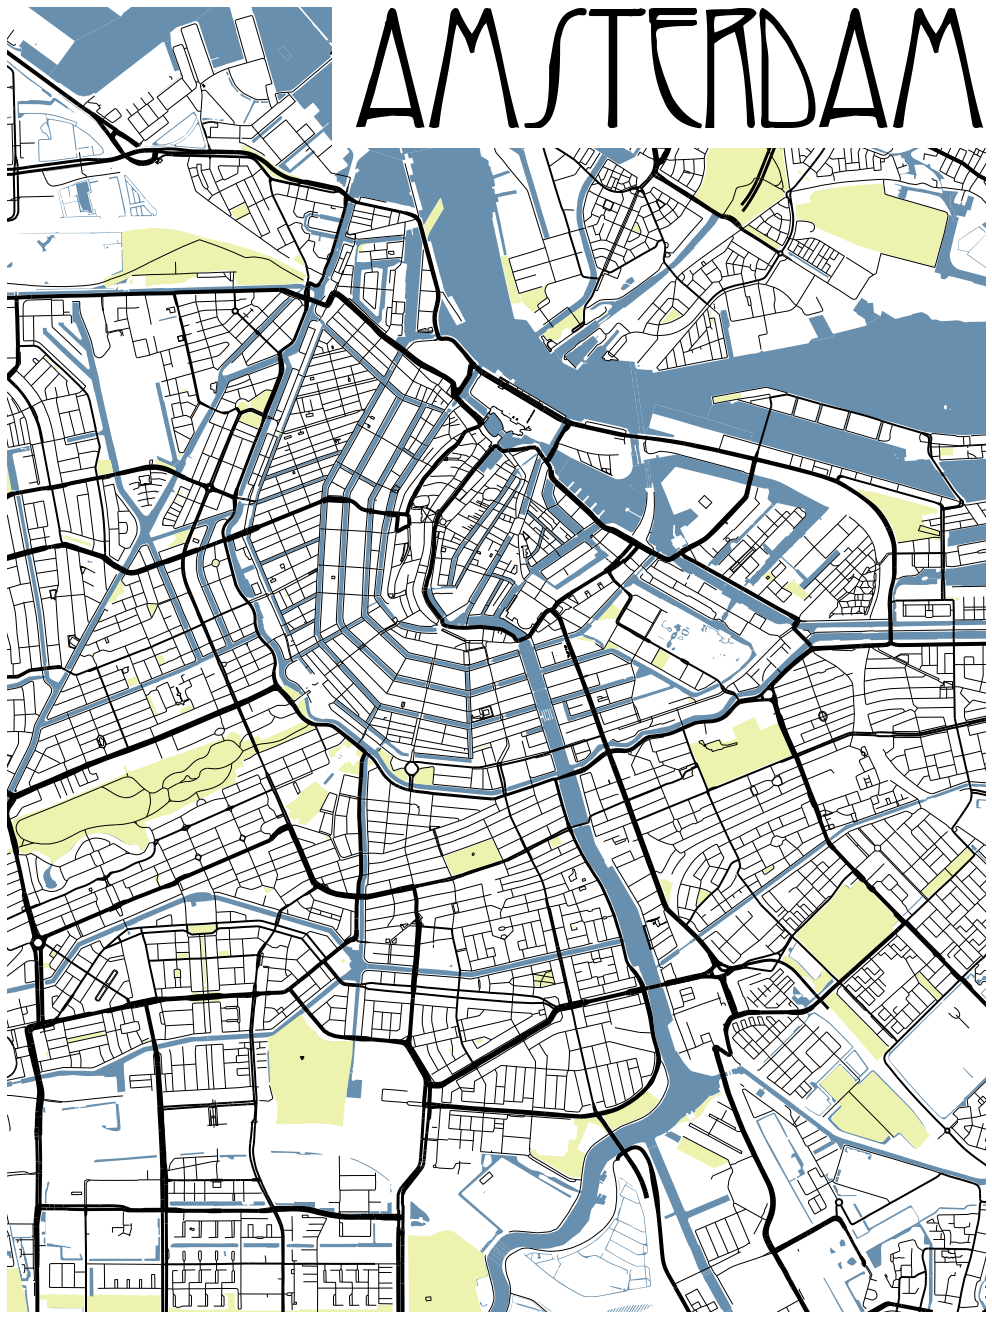

In [9]:
c = "amsterdam"
fig,a = plt.subplots(1,1,figsize=(18,24))
plot_city(conf[c]['folder'],conf[c]['bb'],conf[c]['name'],conf[c]['csr'],a, crop=False,transform=False)
fig.savefig(c+'.png',bbox_inches="tight",dpi=600)